### NLP TP2

La apliación está orientado a ser implementado en una empresa de Hotel para automatizar las respuestas y disminuir el tiempo de contestacion y reducir gasto de personal.

In [21]:
import json
import string
import random 
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchsummary
import os
import platform
import re
import unicodedata
import stanza
import spacy_stanza
import seaborn as sns

In [2]:
def preprocess_clean_text(text):    
    # sacar tildes de las palabras
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntiación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

In [3]:
text = "amigo tienes HABitaciones?.."

# Antes de preprocesar los datos se pasa a mínusculas todo el texto
preprocess_clean_text(text.lower())

'amigo tienes habitaciones'

In [4]:
nlp = spacy_stanza.load_pipeline("es")

2023-06-23 10:52:33 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-06-23 10:54:02 INFO: Loading these models for language: es (Spanish):
| Processor    | Package  |
---------------------------
| tokenize     | ancora   |
| mwt          | ancora   |
| pos          | ancora   |
| lemma        | ancora   |
| constituency | combined |
| depparse     | ancora   |
| sentiment    | tass2020 |
| ner          | conll02  |

2023-06-23 10:54:02 INFO: Using device: cuda
2023-06-23 10:54:02 INFO: Loading: tokenize
2023-06-23 10:54:04 INFO: Loading: mwt
2023-06-23 10:54:04 INFO: Loading: pos
2023-06-23 10:54:04 INFO: Loading: lemma
2023-06-23 10:54:04 INFO: Loading: constituency
2023-06-23 10:54:04 INFO: Loading: depparse
2023-06-23 10:54:05 INFO: Loading: sentiment
2023-06-23 10:54:05 INFO: Loading: ner
2023-06-23 10:54:05 INFO: Done loading processors!


In [73]:
# Ejemplo de como fuciona
text = "holas amigo tienes HABitaciones?.."

# Antes de preprocesar los datos se pasa a mínusculas todo el texto
tokes = nlp(preprocess_clean_text(text.lower()))
print("tokens:", tokes)
print("Lematización de cada token:")
for token in tokes:
    print([token, token.lemma_])

tokens: holas amigo tienes habitaciones
Lematización de cada token:
[holas, 'hola']
[amigo, 'amigo']
[tienes, 'tener']
[habitaciones, 'habitación']


In [74]:
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "Buenas", "¿Qué tal?","Buen dia"],
              "responses": ["Hola! en que puedo ayudarte?", "Hola, bienvenido al Hotel Leopard, en que lo ayudo?"],
             },
             {"tag": "nombre",
              "patterns": ["¿Cúal es tu nombre?", "¿Quién eres?", "¿Con quien hablo?"],
              "responses": ["Mi nombre es LeoBot", "Yo soy LeoBot", "Con LeoBot"]
             },
             
            {"tag": "contacto",
              "patterns": ["contacto", "número de contacto", "número de teléfono", "número de whatsapp", "whatsapp"],
              "responses": ["Podes contactarnos al siguiente 4521321", "Contactos al whatsapp 95842234"]
             },
            {"tag": "cochera",
              "patterns": ["¿Tiene cochera?", "¿Tengo movilidad, quiero cochera?","¿tiene espacio en cochera?"],
              "responses": ["El Hotel cuenta con cochera suficiente para todos los huespedes, no se preocupe."]
             },
            {"tag": "precios",
              "patterns": ["precio de habitacion?", "Me podrás pasar los precios", "¿Cuánto esta?", "¿Cuánto sale?","¿los precios?"],
              "responses": ["Los precios de las habitaciones son las siguientes, habitacion individual a $60, habitacion doble a $100 y habitacion Queen a $160"]
             },
            {"tag": "pagos",
              "patterns": ["medios de pago", "tarjeta de crédito", "tarjeta debito", "plin o yape","¿para cancelar?","el pago","para cancelar"],
              "responses": ["Puede realizar la reserva por la pagina web www.leopard-hotel.com ó por medio fisico con tarjeta o transferencia"]
             },
            {"tag": "disponibilidad",
              "patterns": ["¿Hay habitaciones?", "¿Tiene habitaciones?", "¿Hoy hay habitaciones?"],
              "responses": ["Puede resalizar la reserva por la pagina web www.leopard-hotel.com"]
             },
            {"tag": "agradecimientos",
              "patterns": [ "Muchas gracias", "Gracias","eso es todo"],
              "responses": ["Que tenga buen dia, cualquier otra consulta puedes escribirme"]
             },
             {"tag": "despedida",
              "patterns": [ "Ok nos vemos", "Hasta luego!", "chau", "bye"],
              "responses": ["Hasta luego!", "Hablamos luego!"]
             }
]}

In [75]:
# Datos que necesitaremos, las palabras o vocabilario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para lamacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [76]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['buen', 'bye', 'cancelar', 'chau', 'cochera', 'con', 'contacto', 'credito', 'cual', 'cuanto', 'de', 'debito', 'dia', 'el', 'en', 'ese', 'espacio', 'este', 'gracias', 'haber', 'habitacion', 'habitación', 'hablar', 'hasta', 'hola', 'hoy', 'luego', 'medio', 'movilidad', 'mucho', 'nombre', 'numero', 'o', 'ok', 'pago', 'para', 'pasar', 'plin', 'poder', 'precio', 'que', 'querer', 'quien', 'salir', 'ser', 'tal', 'tarjeta', 'telefono', 'tener', 'todo', 'tu', 'ver', 'whatsapp', 'yape', 'yo']
classes: ['agradecimientos', 'bienvenida', 'cochera', 'contacto', 'despedida', 'disponibilidad', 'nombre', 'pagos', 'precios']
doc_X: ['Hola', 'Buenas', '¿Qué tal?', 'Buen dia', '¿Cúal es tu nombre?', '¿Quién eres?', '¿Con quien hablo?', 'contacto', 'número de contacto', 'número de teléfono', 'número de whatsapp', 'whatsapp', '¿Tiene cochera?', '¿Tengo movilidad, quiero cochera?', '¿tiene espacio en cochera?', 'precio de habitacion?', 'Me podrás pasar los precios', '¿Cuánto esta?', '¿Cuánto sale?', 

In [77]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))
# Cantidad de tags
print("Tags:", len(classes))

Vocabulario: 55
Tags: 9


In [78]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 1, 0, 0]


In [79]:
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.float32))
        # las loss function esperan la salida float
        self.y = torch.from_numpy(y.astype(np.float32))

        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(train_X, train_y)

input_dim = data_set.x.shape[1]
print("Input dim", input_dim)

output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

Input dim 55
Output dim 9


In [80]:
from torch.utils.data import DataLoader

train_loader = DataLoader(data_set, batch_size=32, shuffle=False)

In [114]:
class Model1(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_features=input_dim, out_features=128) # fully connected layer
        self.fc2 = nn.Linear(in_features=128, out_features=64) # fully connected layer
        self.fc3 = nn.Linear(in_features=64, out_features=output_dim) # fully connected layer
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1) # normalize in dim 1
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.softmax(self.fc3(out))
        return out

# Crear el modelo basado en la arquitectura definida
model1 = Model1(input_dim=input_dim, output_dim=output_dim)
# Crear el optimizador la una función de error
model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.005)
model1_criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

torchsummary.summary(model1, input_size=(1, input_dim), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]           7,168
              ReLU-2               [-1, 1, 128]               0
           Dropout-3               [-1, 1, 128]               0
            Linear-4                [-1, 1, 64]           8,256
              ReLU-5                [-1, 1, 64]               0
           Dropout-6                [-1, 1, 64]               0
            Linear-7                 [-1, 1, 9]             585
           Softmax-8                 [-1, 1, 9]               0
Total params: 16,009
Trainable params: 16,009
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


In [115]:
from torch_helpers import categorical_acc

def train(model, train_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []

    ## Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data)

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()
            
            # Calculo el accuracy del batch
            accuracy = categorical_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error y accuracy para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)        
        train_accuracy.append(epoch_train_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
    }
    
    return history

In [116]:
history1 = train(model1,
                train_loader,
                model1_optimizer,
                model1_criterion,
                epochs=120
                )

Epoch: 1/120 - Train loss 2.198 - Train accuracy 0.047
Epoch: 2/120 - Train loss 2.195 - Train accuracy 0.062
Epoch: 3/120 - Train loss 2.192 - Train accuracy 0.225
Epoch: 4/120 - Train loss 2.184 - Train accuracy 0.425
Epoch: 5/120 - Train loss 2.174 - Train accuracy 0.456
Epoch: 6/120 - Train loss 2.172 - Train accuracy 0.472
Epoch: 7/120 - Train loss 2.166 - Train accuracy 0.294
Epoch: 8/120 - Train loss 2.144 - Train accuracy 0.425
Epoch: 9/120 - Train loss 2.128 - Train accuracy 0.441
Epoch: 10/120 - Train loss 2.127 - Train accuracy 0.394
Epoch: 11/120 - Train loss 2.107 - Train accuracy 0.425
Epoch: 12/120 - Train loss 2.077 - Train accuracy 0.409
Epoch: 13/120 - Train loss 1.989 - Train accuracy 0.409
Epoch: 14/120 - Train loss 1.985 - Train accuracy 0.409
Epoch: 15/120 - Train loss 1.958 - Train accuracy 0.494
Epoch: 16/120 - Train loss 1.927 - Train accuracy 0.394
Epoch: 17/120 - Train loss 1.882 - Train accuracy 0.525
Epoch: 18/120 - Train loss 1.903 - Train accuracy 0.588
E

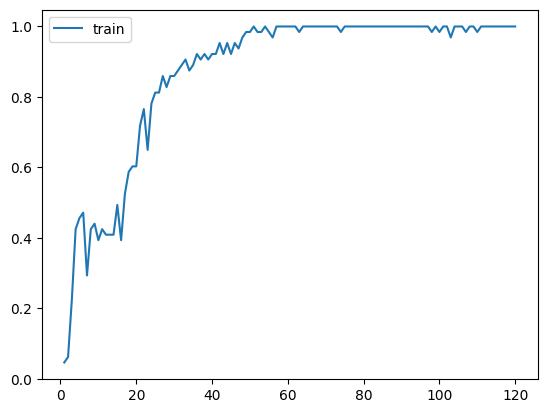

In [117]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
plt.show()

In [68]:
def text_to_tokens(text): 
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0:
        x = torch.from_numpy(np.array([bow]).astype(np.float32))
        result = model1(x)[0].detach().numpy()
        thresh = 0.2
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        y_pred.sort(key=lambda x: x[1], reverse=True)

        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]
    list_of_intents = intents_json["intents"]
    for i in list_of_intents: 
        if i["tag"] == tag:
            result = "BOT: " + random.choice(i["responses"])
            break
    return result

In [69]:
message = "Buenas"
intents = pred_class(message, words, classes)
if len(intents) > 0:
    result = get_response(intents, dataset)
    print(result)

BOT: Hola! en que puedo ayudarte?


In [70]:
while True:
    message = input("")
    
    if message=='exit':
        break
    
    print('PREGUNTA: ',message)
    
    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print('RESPUESTA ',result)
    else:
        print("Perdón, no comprendo la pregunta.")
    
    

PREGUNTA:  hola
RESPUESTA  BOT: Hola, bienvenido al Hotel Leopard, en que lo ayudo?
PREGUNTA:  tienes cochera?
RESPUESTA  BOT: El Hotel cuenta con cochera suficiente para todos los huespedes, no se preocupe.
PREGUNTA:  el pago puedo hacerlo con tarjeta?
RESPUESTA  BOT: Puede realizar la reserva por la pagina web www.leopard-hotel.com ó por medio fisico con tarjeta o transferencia
PREGUNTA:  los precios de las habitaciones?
RESPUESTA  BOT: Los precios de las habitaciones son las siguientes, habitacion individual a $60, habitacion doble a $100 y habitacion Queen a $160
PREGUNTA:  ok gracias
RESPUESTA  BOT: Hasta luego!
PREGUNTA:  nos vemos
RESPUESTA  BOT: Hasta luego!


Conslusiones:

- El modelo implementado para la generación de un bot obtiene respuestas acordes a la solicitud.

- El modelo se puede mejorar incrementando los tokens realacionados a cada clase.

- La aplicación y los datos utilizados son para una aplicación de brindar información de un Hotel.

- Aumentandoi ligeramente la tasa de aprendizaje el modelo logra con mejor precision y en menos epocas.